### Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid

### Loading data

In [5]:
data = load_breast_cancer(as_frame=True)

# loading data
X = data.data
y = data.target

# combining data
breast_df = pd.concat([X, y], axis=1)

# displaying data
breast_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


### KNN Clasifier (from Lab3 assigement)

In [24]:
class kNN_Classificator:
    def __init__(self, k:int, data:pd.DataFrame, classes: pd.Series, p=None):
        self.k = k
        self.data = data
        self.classes = classes
        self.cm = None
        self.p = p

    def split_data(self, test_size:float, random_state:int=42):
        x_train, x_test, y_train, y_test = train_test_split(self.data, self.classes, test_size=test_size, random_state=random_state)
        return x_train, x_test, y_train, y_test

    def scale_data(self, data:pd.DataFrame):
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data)
        return scaled_data

    # create a model
    def train(self, x_train: pd.DataFrame, y_train: pd.Series, p=2):
        model = KNeighborsClassifier(n_neighbors=self.k, p=p)
        model.fit(x_train, y_train)
        return model

    # make predictions for accuracy
    def predict(self, model, x_test: pd.DataFrame):
        predictions = model.predict(x_test)
        return predictions

    # calculate accuracy
    def calculate_accuracy(self, predictions: np.array, y_test: pd.Series):
        accuracy = accuracy_score(y_test, predictions)
        return accuracy

    # get confusion matrix
    def get_confusion_matrix(self, model, x_test: pd.DataFrame, y_test: pd.Series):
        predictions = model.predict(x_test)
        cm = confusion_matrix(y_test, predictions)

        self.cm = cm

        return cm

    def show_confusion_matrix(self, labels):
        if self.cm is not None:
            disp = ConfusionMatrixDisplay(confusion_matrix=self.cm, display_labels=labels)
            disp.plot()

    def calculate_precision(self):
        if self.cm is not None:
            tn, fp, fn, tp = self.cm.ravel()
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            return precision
        else:
            return None

    def calculate_recall(self):
        if self.cm is not None:
            tn, fp, fn, tp = self.cm.ravel()
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            return recall
        else:
            return None

    def calculate_f1_score(self):
        precision = self.calculate_precision()
        recall = self.calculate_recall()
        if precision is not None and recall is not None and (precision + recall) > 0:
            f1_score = 2 * (precision * recall) / (precision + recall)
            return f1_score
        else:
            return None

    def create_classification_report(self, y_test: pd.Series, predictions: np.array, labels: list, output_dict: bool = False):

        class_report = classification_report(y_test,predictions, labels=labels, output_dict=output_dict)

        print(str(class_report))


    def k_fold_validation(self, k:int, p=2):

        data = self.data
        classes = self.classes

        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        kf.get_n_splits(data)

        accuracies = []

        for train_index, test_index in kf.split(data):
            # take data
            x_train, x_test = data.iloc[train_index], data.iloc[test_index]
            y_train, y_test = classes.iloc[train_index], classes.iloc[test_index]

            # scalte data
            scaled_x_train = self.scale_data(x_train)
            scaled_x_test = self.scale_data(x_test)

            # train and test model
            model = self.train(scaled_x_train, y_train, p)
            predictions = self.predict(model, scaled_x_test)

            accuracy = self.calculate_accuracy(predictions, y_test)

            # append accuracy
            accuracies.append(accuracy)

        return accuracies


# k-Cross Validation

1. We’ll reuse last session’s notebook (wine data and k-NN, with knn = 7 and random seed set).

2. Use KFold to produce data splits for your CV setup. Make sure to store the predictions on each test fold and print the classification_report after looping over all folds.

3. Experiment with different settings of folds kcv = 3 and kcv = 10.



In [25]:
k_cros_kNN = kNN_Classificator(7, X, y)
accuracy_10 = k_cros_kNN.k_fold_validation(10)
accuracy_3 = k_cros_kNN.k_fold_validation(3)
accuracy_7 = k_cros_kNN.k_fold_validation(7)

def plot_k_fold_accuracies(accuracies: list, ax=None):

    folds = len(accuracies)
    mean_accuracy = round(np.mean(accuracies), 2)

    if ax is None:
        ax = plt.gca()

    ax.plot([i for i in range(len(accuracies))], accuracies, marker='o')
    ax.axhline(y=mean_accuracy, color='r', linestyle='--', label=f'Mean accuracy: {mean_accuracy}')
    ax.set_xlabel('Fold')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Accuracy for each fold for {folds} folds')
    ax.legend()
    ax.grid()

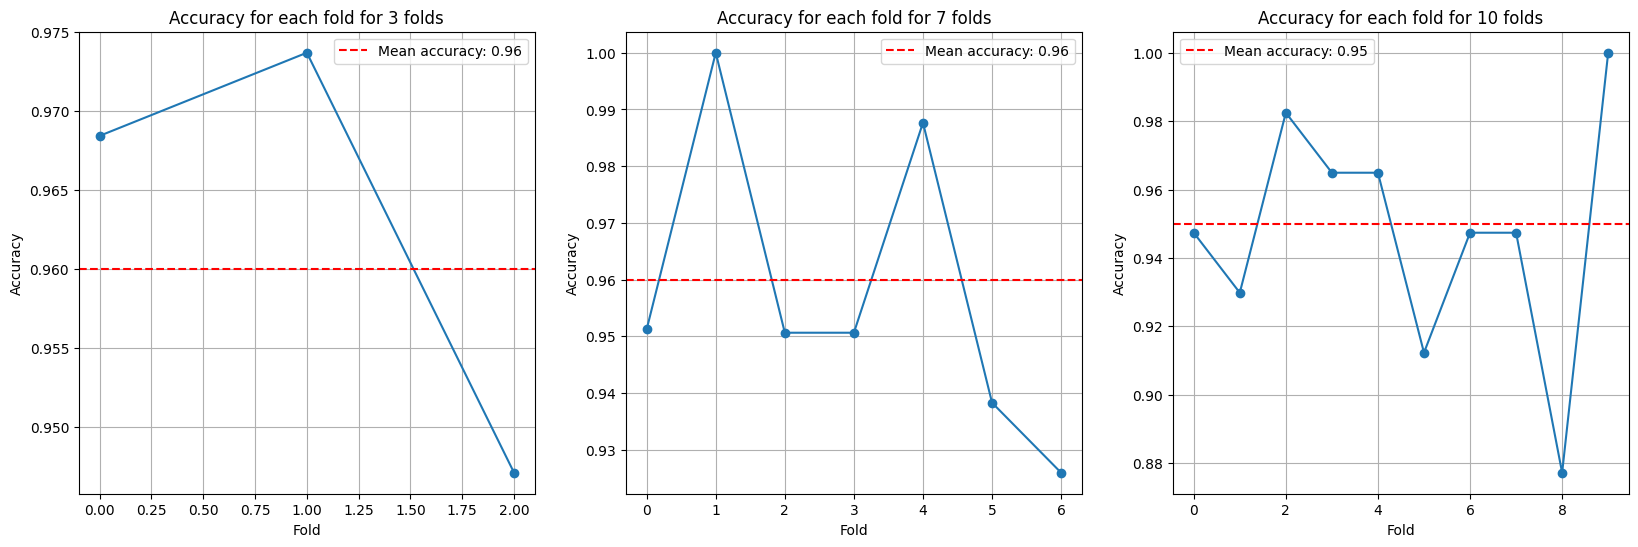

In [23]:
ax, fig = plt.subplots(1, 3, figsize=(20, 6))

plot_k_fold_accuracies(accuracy_3, ax=fig[0])
plot_k_fold_accuracies(accuracy_7, ax=fig[1])
plot_k_fold_accuracies(accuracy_10, ax=fig[2])

# Grid Search and Cross Validation (Option 1)

1. Implement GS in combination with CV relying on ParameterGrid and KFold using the wine data.
2. Specify a set of values for the two parameters n_neighbors and p. Try to select reasonable values for both, discuss the reasons for your selection with your partner.
3. Implement a for loop that iterates over all combinations of the grid and correctly implements CV as well as performance evaluation over all folds. The sample code below might help you to do this.
4. Find out which combination of parameters performs best using the performance measure of your choosing.


In [29]:
n_neighbors = [i for i in range(1, 30)]
p = [1, 2]
k_cross_valdation = 10

param_grid = ParameterGrid({'n_neighbors': n_neighbors, 'p': p})

current_best_acc = 0

current_best_k = 0
current_best_p = 0

for params in param_grid:
    k = params['n_neighbors']
    p = params['p']

    k_cros_kNN = kNN_Classificator(k, X, y, p)
    accuracies = k_cros_kNN.k_fold_validation(k_cross_valdation, p)

    mean_accuracy = np.mean(accuracies)

    if mean_accuracy > current_best_acc:
        current_best_acc = mean_accuracy
        current_best_k = k
        current_best_p = p

    print(f'For n={k} neighbours and p={p} the mean accuracy is: {round(mean_accuracy,4)} %')

print(f'The best accuracy is: {current_best_acc} % for n={current_best_k} and p={current_best_p}')

For n=1 neighbours and p=1 the mean accuracy is: 0.9508 %
For n=1 neighbours and p=2 the mean accuracy is: 0.9333 %
For n=2 neighbours and p=1 the mean accuracy is: 0.9367 %
For n=2 neighbours and p=2 the mean accuracy is: 0.9367 %
For n=3 neighbours and p=1 the mean accuracy is: 0.9614 %
For n=3 neighbours and p=2 the mean accuracy is: 0.9543 %
For n=4 neighbours and p=1 the mean accuracy is: 0.9666 %
For n=4 neighbours and p=2 the mean accuracy is: 0.9525 %
For n=5 neighbours and p=1 the mean accuracy is: 0.9596 %
For n=5 neighbours and p=2 the mean accuracy is: 0.9561 %
For n=6 neighbours and p=1 the mean accuracy is: 0.9649 %
For n=6 neighbours and p=2 the mean accuracy is: 0.9544 %
For n=7 neighbours and p=1 the mean accuracy is: 0.9579 %
For n=7 neighbours and p=2 the mean accuracy is: 0.9474 %
For n=8 neighbours and p=1 the mean accuracy is: 0.9666 %
For n=8 neighbours and p=2 the mean accuracy is: 0.9561 %
For n=9 neighbours and p=1 the mean accuracy is: 0.9544 %
For n=9 neighb

# Grid Search and Cross Validation (Option 2)
1. Have a look at the documentation of GridSearchCV, a class that automatically combines GS and CV for you, but has the disadvantage of being less adaptable than looping over the ParameterGrid and implementing KFold yourself.

2. You may reuse the KNeighborsClassifier as well as the ParameterGrid you already defined for option 1.

3. Set kcv = 10.

4. Evaluate the results using GridSearchCV built-in methods.

5. What evaluation measure is used per default in GridSearchCV’s scoring when deciding for the best model? Find out and change it to use F1-score.

6. Find out how you access the best model’s parameters.

In [ ]:
from sklearn.model_selection import GridSearchCV

n_neighbors = [i for i in range(1, 30)]
p = [1, 2]
k_cross_valdation = 10

param_grid = ParameterGrid({'n_neighbors': n_neighbors, 'p': p})
kNN = kNN_Classificator(7, X, y)

GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, cv=k_cross_valdation, n_jobs=-1, verbose=1)
